# Chapter 14 - Use and Remove Seasonality

Time series datasets can contain a seasonal component. **This is a cycle that repeats over time, such as monthly or yearly**. This repeating cycle may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models.

After completing this tutorial, you will know:
- The **denition of seasonality in time series** and the opportunity it provides for forecasting with machine learning methods.
- How to use the difference method to **create a seasonally adjusted** time series of daily temperature data.
- How to model the seasonal component directly and explicitly subtract it from observations.

## 14.1 Seasonality in Time Series

Seasonal variation, or seasonality, are cycles that repeat regularly over time.

** A repeating pattern within each year is known as seasonal variation, although the term is applied more generally to repeating patterns within any xed period.**

A cycle structure in a time series may or may not be seasonal. If it consistently repeats at the same frequency, it is seasonal, otherwise it is not seasonal and is called a cycle.

## 14.1.1 Benefits to Machine Learning

Understanding the seasonal component in time series can improve the performance of modeling with machine learning.

- **Clearer Signal**: Identifying and removing the seasonal component from the time series `can result in a clearer relationship between input and output variables`.
* **More Information**: Additional information about the seasonal component of the time series can provide new information to improve model performance.

### 14.1.2 Types of Seasonality

There are many types of seasonality; for example: Time of Day, Daily, Weekly, Monthly, Yearly.

### 14.1.3 Removing Seasonality

Once seasonality is identied, it can be modeled. The model of seasonality can be removed from the time series. This process is **called Seasonal Adjustment, or Deseasonalizing**. A time series where the seasonal component has been removed is **called seasonal stationary**. A **time series with a clear seasonal component is referred to as non-stationary**.

## 14.2 Minimum Daily Temperatures Dataset

This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.

## 14.3 Seasonal Adjustment with Differencing

If there is a seasonal component at the level of one week, then **we can remove it on an observation today by subtracting the value from last week**.

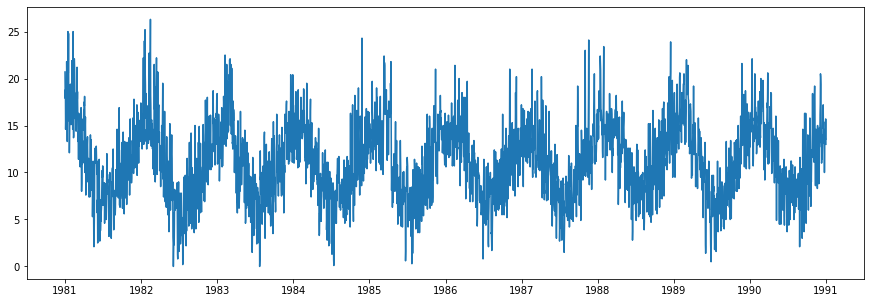

In [27]:
# deseasonalize a time series using differencing
from pandas import read_csv
from matplotlib import pyplot
from pylab import rcParams

%matplotlib inline

csvfile = '.\\code\\chapter_14\\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

rcParams['figure.figsize'] = 15, 5
pyplot.plot(series)
pyplot.show()

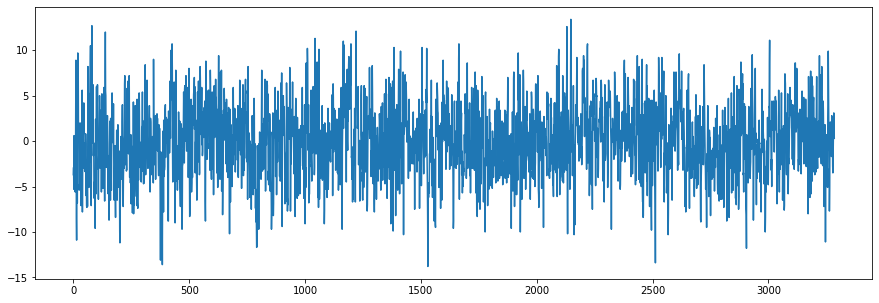

In [28]:
X = series.values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
    value = X[i] - X[i - days_in_year]
    diff.append(value)

rcParams['figure.figsize'] = 15, 5
pyplot.plot(diff)
pyplot.show()

Date
1981-01-31    17.712903
1981-02-28    17.678571
1981-03-31    13.500000
1981-04-30    12.356667
1981-05-31     9.490323
1981-06-30     7.306667
1981-07-31     7.577419
1981-08-31     7.238710
1981-09-30    10.143333
1981-10-31    10.087097
Freq: M, Name: Temp, dtype: float64


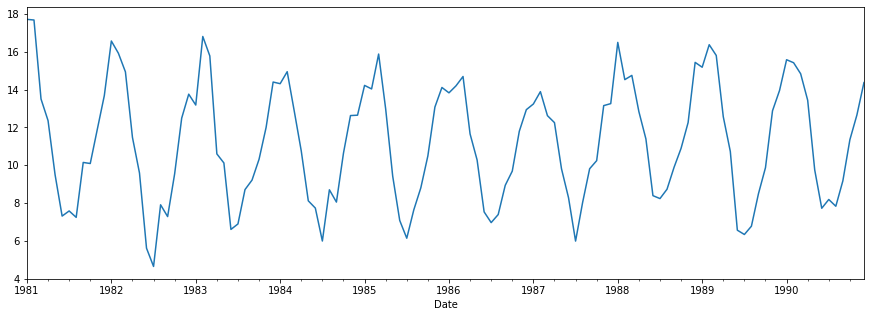

In [29]:
# calculate and plot monthly average
from pandas import read_csv
from matplotlib import pyplot

csvfile = '.\\code\\chapter_14\\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

resample = series.resample('M')
monthly_mean = resample.mean()
print(monthly_mean.head(10))

rcParams['figure.figsize'] = 15, 5
monthly_mean.plot()
pyplot.show()

We can shortcut this idea and consider all temperatures within a calendar month to be stable. An improved model may be to subtract the average temperature from the same calendar month in the previous year, rather than the same day.

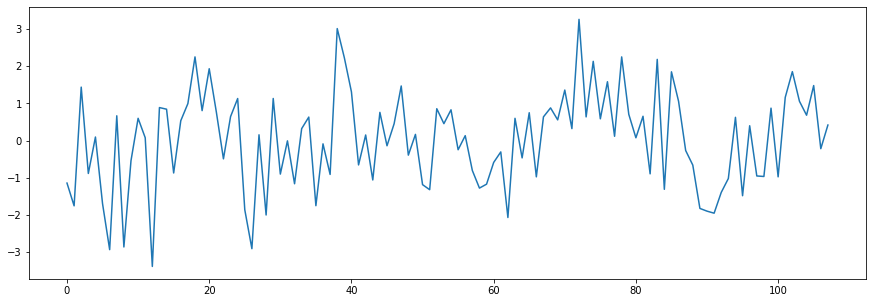

In [30]:
# deseasonalize monthly data by differencing
from pandas import read_csv
from matplotlib import pyplot

csvfile = '.\\code\\chapter_14\\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

resample = series.resample('M')
monthly_mean = resample.mean()

diff = list()
months_in_year = 12
for i in range(months_in_year, len(monthly_mean)):
    value = monthly_mean[i] - monthly_mean[i - months_in_year]
    diff.append(value)

rcParams['figure.figsize'] = 15, 5
pyplot.plot(diff)
pyplot.show()

Next, we can use the monthly average minimum temperatures from the same month in the previous year to adjust the daily minimum temperature dataset. Again, we just skip the first year of data, but the correction using the monthly rather than the daily data may be a more stable approach.

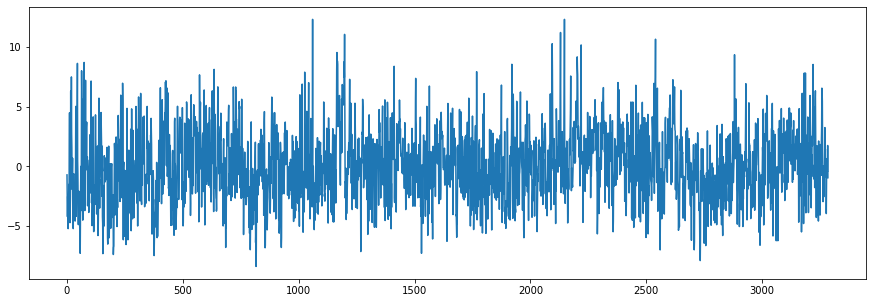

In [31]:
# deseasonalize a time series using month-based differencing
from pandas import read_csv
from matplotlib import pyplot

csvfile = '.\\code\\chapter_14\\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

X = series.values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
    month_str = str(series.index[i].year-1)+'-'+str(series.index[i].month)
    month_mean_last_year = series[month_str].mean()
    value = X[i] - month_mean_last_year
    diff.append(value)

rcParams['figure.figsize'] = 15, 5
pyplot.plot(diff)
pyplot.show()

## 14.4 Seasonal Adjustment with Modeling

We can model the seasonal component directly, then subtract it from the observations. The seasonal component in a given time series is likely a sine wave over a generally xed period and amplitude. This can be approximated easily using a curve-tting method.

Once t, the model can then be used to calculate a seasonal component for any time index. In the case of the temperature data, the time index would be the day of the year. We can then estimate the seasonal component for the day of the year for any historical observations or any new observations in the future. The curve can then be used as a new input for modeling with supervised learning algorithms, or subtracted from observations to create a seasonally adjusted series.

Coefficients: [-1.17308000e-08  9.30253946e-06 -2.15977594e-03  1.19147966e-01
  1.38980178e+01]


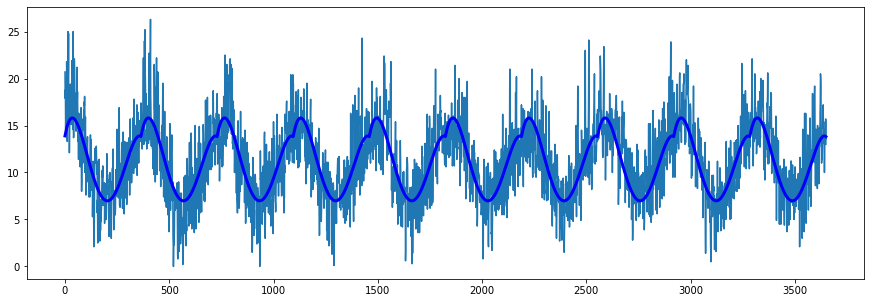

In [32]:
# model seasonality with a polynomial model
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit

csvfile = '.\\code\\chapter_14\\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
y = series.values
degree = 4

# Once the dataset is prepared, we can create the t by calling the polyfit() function passing
# the x-axis values (integer day of year), y-axis values (temperature observations), and the order
# of the polynomial.
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)

# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plot curve over original data
rcParams['figure.figsize'] = 15, 5
pyplot.plot(series.values)
pyplot.plot(curve, color='blue', linewidth=3)
pyplot.show()

Running the example creates the dataset, ts the curve, predicts the value for each day in the dataset, and then plots the resulting seasonal model over the top of the original dataset. One limitation of this model is that it does not take into account of leap days, adding small offset noise that could easily be corrected with an update to the approach. For example, **we could just remove the two February 29 observations from the dataset when creating the seasonal model**.

The curve appears to be a good t for the seasonal structure in the dataset. We can now use this model to create a seasonally adjusted version of the dataset.

Coefficients: [-1.17308000e-08  9.30253946e-06 -2.15977594e-03  1.19147966e-01
  1.38980178e+01]


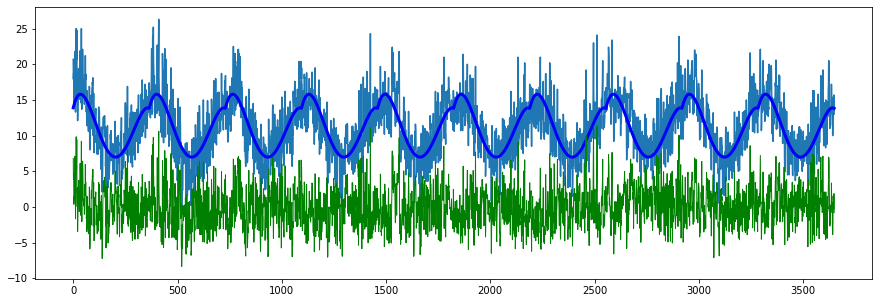

In [33]:
# model seasonality with a polynomial model
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit

csvfile = '.\\code\\chapter_14\\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
y = series.values
degree = 4

# Once the dataset is prepared, we can create the t by calling the polyfit() function passing
# the x-axis values (integer day of year), y-axis values (temperature observations), and the order
# of the polynomial.
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)

# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# create seasonally adjusted
values = series.values
mdiff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    mdiff.append(value)

# plot curve over original data
rcParams['figure.figsize'] = 15, 5
pyplot.plot(series.values)
pyplot.plot(curve, color='blue', linewidth=3)
pyplot.plot(mdiff, color='green', linewidth=1)
pyplot.show()

## Seasonal Adjustment with Modeling

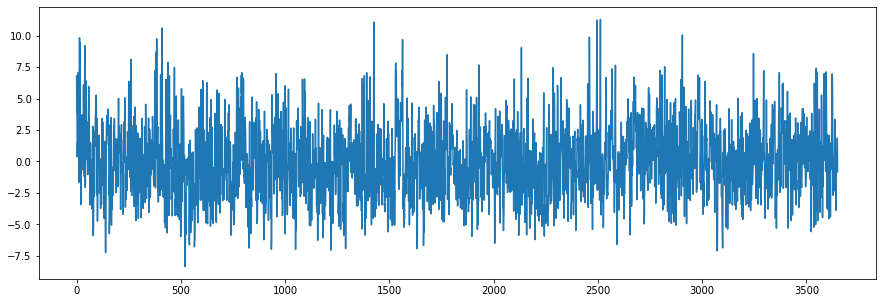

In [34]:
# plot curve over original data
rcParams['figure.figsize'] = 15, 5
pyplot.plot(mdiff)
pyplot.show()

## Seasonal Adjustment with Differencing

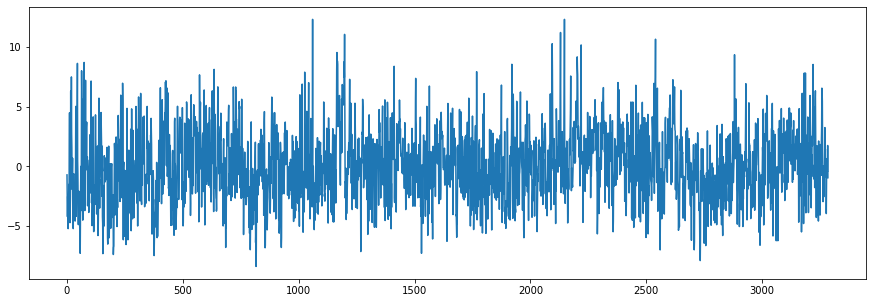

In [35]:
# plot curve over original data by di
rcParams['figure.figsize'] = 15, 5
pyplot.plot(diff)
pyplot.show()

Running the example subtracts the values predicted by the seasonal model from the original observations. The The seasonally adjusted dataset is then plotted.